### Import dependencies

In [ ]:
pip install -q hyperopt

In [ ]:
pip install -q pyts

In [6]:
import warnings
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
from pyts.multivariate.classification import MultivariateClassifier
import os
import pandas as pd
import dask.dataframe as dd
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from pyts.preprocessing import InterpolationImputer
import numpy as np
from pyts.datasets import load_gunpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp,fmin,anneal
from hyperopt import Trials
from sklearn.base import clone
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

### read partitional data

In [8]:
# read the normalized balanced .npy persistent data 
def read_data(X_path, y_path):
    
    X = np.load(X_path)
    y = np.load(y_path)
    
    return X, y


In [66]:
#normalized/sampled swansf with 60 points
# Define the base directory where the data is stored
base_dir = 'normalized_data'

# Load the data using relative paths
X_norm_part1, y_norm_part1 = read_data(os.path.join(base_dir, 'X_norm_part1.npy'), 
                                       os.path.join(base_dir, 'y_norm_part1.npy'))

X_norm_part2, y_norm_part2 = read_data(os.path.join(base_dir, 'X_norm_part2.npy'), 
                                       os.path.join(base_dir, 'y_norm_part2.npy'))

X_norm_part3, y_norm_part3 = read_data(os.path.join(base_dir, 'X_norm_part3.npy'), 
                                       os.path.join(base_dir, 'y_norm_part3.npy'))

X_norm_part4, y_norm_part4 = read_data(os.path.join(base_dir, 'X_norm_part4.npy'), 
                                       os.path.join(base_dir, 'y_norm_part4.npy'))

X_norm_part5, y_norm_part5 = read_data(os.path.join(base_dir, 'X_norm_part5.npy'), 
                                       os.path.join(base_dir, 'y_norm_part5.npy'))


In [28]:
#sliced data
# Define base directories
X_base_dir = 'Sliced_Datasets'
y_base_dir = 'normalized_data'

# Load the data using relative paths
X_norm_part1, y_norm_part1 = read_data(os.path.join(X_base_dir, 'X_norm_part1_8.npy'), 
                                       os.path.join(y_base_dir, 'y_norm_part1.npy'))

X_norm_part2, y_norm_part2 = read_data(os.path.join(X_base_dir, 'X_norm_part2_8.npy'), 
                                       os.path.join(y_base_dir, 'y_norm_part2.npy'))

X_norm_part3, y_norm_part3 = read_data(os.path.join(X_base_dir, 'X_norm_part3_8.npy'), 
                                       os.path.join(y_base_dir, 'y_norm_part3.npy'))

X_norm_part4, y_norm_part4 = read_data(os.path.join(X_base_dir, 'X_norm_part4_8.npy'), 
                                       os.path.join(y_base_dir, 'y_norm_part4.npy'))

X_norm_part5, y_norm_part5 = read_data(os.path.join(X_base_dir, 'X_norm_part5_8.npy'), 
                                       os.path.join(y_base_dir, 'y_norm_part5.npy'))


In [67]:
#original shape of swan-sf
X_norm_part1.shape

(2508, 60, 5)

In [68]:
#transpose data shape for 3d-TSF MVTS classifier
X_norm_part1 = np.transpose(X_norm_part1, (0, 2, 1))
X_norm_part2 = np.transpose(X_norm_part2, (0, 2, 1))
X_norm_part3 = np.transpose(X_norm_part3, (0, 2, 1))
X_norm_part4 = np.transpose(X_norm_part4, (0, 2, 1))
X_norm_part5 = np.transpose(X_norm_part5, (0, 2, 1))


In [71]:
#converted shape of swan-sf
X_norm_part1.shape

(2508, 5, 60)

### flatten to 2d for RF

In [7]:
#flatten to 2d for random forest
X_norm_part1 = X_norm_part1.reshape(X_norm_part1.shape[0],-1)

In [125]:
#flatten to 2d
X_norm_part2 = X_norm_part2.reshape(X_norm_part2.shape[0],-1)
X_norm_part3 = X_norm_part3.reshape(X_norm_part3.shape[0],-1)
X_norm_part4 = X_norm_part4.reshape(X_norm_part4.shape[0],-1)
X_norm_part5 = X_norm_part5.reshape(X_norm_part5.shape[0],-1)

# TUNING

In [70]:
# tuning for timeseriesforest classifier for normal swan-sf data
# %%timeit
import warnings
warnings.filterwarnings('ignore')

# Define custom scoring functions for TSS and HSS
def true_skill_statistic(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tss = (tp / (tp + fn)) - (fp / (fp + tn))
    return tss

def heidke_skill_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    numerator = 2 * ((tp * tn) - (fp * fn))
    denominator = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = numerator / denominator
    return hss

# Define hyperparameter space
hyperparameter_space = {
'estimator__criterion': hp.choice('estimator__criterion', ['entropy','gini']),
'estimator__n_estimators': hp.randint('estimator__n_estimators', 50, 700),
'estimator__max_depth': hp.choice('estimator__max_depth', [None, 1, 5, 10, 15, 20, 25, 30]),
'estimator__n_windows': hp.randint('estimator__n_windows', 1, 60),
'estimator__min_window_size': hp.choice('estimator__min_window_size', [1, 2, 3]),
'estimator__min_samples_split': hp.randint('estimator__min_samples_split', 2, 5),
'estimator__min_samples_leaf': hp.randint('estimator__min_samples_leaf', 1, 5)
}

# Define the objective function for hyperopt
def objective(space):
    tsf = MultivariateClassifier(estimator=TimeSeriesForest())
    tsf.set_params(**space)
    tsf.fit(X_norm_part1, y_norm_part1)
    
    # Make scorer objects for GridSearchCV
    tss_scorer = make_scorer(true_skill_statistic)
    hss_scorer = make_scorer(heidke_skill_score)
    

    tss_score = np.mean(cross_val_score(tsf,
    X_norm_part1, y_norm_part1,
    cv=5, scoring=tss_scorer,
    n_jobs=-1))

    hss_score = np.mean(cross_val_score(tsf,
    X_norm_part1, y_norm_part1,
    cv=5, scoring=hss_scorer,
    n_jobs=-1))

    return {'loss': -1 * (tss_score + hss_score)/2, # Negative TSS because hyperopt minimizes the loss
    'status': STATUS_OK,
    'tss': tss_score,
    'hss': hss_score}

# Run the hyperparameter optimization
best_100 = fmin(objective,
space=hyperparameter_space,
algo=anneal.suggest,
max_evals=50,
rstate=np.random.default_rng(0))

print("Best hyperparameters found:")
print(best_100) 

100%|██████████| 50/50 [1:18:02<00:00, 93.65s/trial, best loss: -0.8412966383546686] 
Best hyperparameters found:
{'estimator__criterion': 0, 'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'estimator__min_window_size': 0, 'estimator__n_estimators': 242, 'estimator__n_windows': 15}


In [126]:
# %%time
#tuning for random forest classifier
import warnings
warnings.filterwarnings('ignore')

# Define custom scoring functions for TSS and HSS
def true_skill_statistic(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     numerator = tp * tn - fp * fn
#     denominator = (tp + fn) * (fp + tn) + (tp + fp) * (fn + tn)
    tss = (tp / (tp + fn)) - (fp / (fp + tn))
#     tss = numerator / denominator
    return tss

def heidke_skill_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    numerator = 2 * ((tp * tn) - (fp * fn))
    denominator = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = numerator / denominator
    return hss

# Define hyperparameter space
hyperparameter_space = {
'criterion': hp.choice('criterion', ['entropy','gini']),
'n_estimators': hp.randint('n_estimators', 50, 700),
'max_depth': hp.choice('max_depth', [None, 1, 5, 10, 15, 20, 25, 30]),
# 'estimator__n_windows': hp.randint('estimator__n_windows', 1, 60),
# 'estimator__min_window_size': hp.choice('estimator__min_window_size', [1, 2, 3]),
'min_samples_split': hp.randint('min_samples_split', 2, 5),
'min_samples_leaf': hp.randint('min_samples_leaf', 1, 5)
}


# Define the objective function for hyperopt
def objective(space):
    tsf = RandomForestClassifier()
    tsf.set_params(**space)
    tsf.fit(X_norm_part1, y_norm_part1)
    
    # Make scorer objects for GridSearchCV
    tss_scorer = make_scorer(true_skill_statistic)
    hss_scorer = make_scorer(heidke_skill_score)
    
    tss_score = np.mean(cross_val_score(tsf,
    X_norm_part1, y_norm_part1,
    cv=5, scoring=tss_scorer,
    n_jobs=-1))

    hss_score = np.mean(cross_val_score(tsf,
    X_norm_part1, y_norm_part1,
    cv=5, scoring=hss_scorer,
    n_jobs=-1))

    return {'loss': -1 * (tss_score + hss_score)/2, # Negative TSS because hyperopt minimizes the loss
    'status': STATUS_OK,
    'tss': tss_score,
    'hss': hss_score}

# Run the hyperparameter optimization
best_100 = fmin(objective,
space=hyperparameter_space,
algo=anneal.suggest,
max_evals=50,
rstate=np.random.default_rng(0))

print("Best hyperparameters found:")
print(best_100) 

100%|██████████| 50/50 [1:18:12<00:00, 93.85s/trial, best loss: -0.8456863603065139] 
Best hyperparameters found:
{'criterion': 0, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


# TSF Lossy & Lossless Reconstruction

### TSF Original Data

In [81]:
# Number of runs
n_runs = 10

# List to store scores for all partitions and runs
tss_scores_all = {2: [], 3: [], 4: [], 5: []}
hss_scores_all = {2: [], 3: [], 4: [], 5: []}

# Test partitions and corresponding labels
test_partitions = {
    2: (X_norm_part2, y_norm_part2),
    3: (X_norm_part3, y_norm_part3),
    4: (X_norm_part4, y_norm_part4),
    5: (X_norm_part5, y_norm_part5),
}

for run in range(n_runs):
    print(f"Run {run + 1}:")
    
    # Initialize the TimeSeriesForest classifier (ensure no fixed random_state for variability)
    tsf = MultivariateClassifier(TimeSeriesForest(
        max_depth=25, 
        min_window_size=1, 
        n_estimators=242, 
        n_windows=15, 
        min_samples_split=3, 
        min_samples_leaf=1, 
        criterion='entropy'
    ))
    
    # Fit the classifier on the training data
    tsf.fit(X_norm_part1, y_norm_part1)
    
    # Evaluate on each test partition
    for part_num, (X_test, y_test) in test_partitions.items():
        # Predict on the test data
        predictions = tsf.predict(X_test)
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test, predictions)
        
        # Extract values from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Compute TSS and HSS
        tss = (tp / (tp + fn)) - (fp / (fp + tn))
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        
        # Print scores for the current partition
        print(f"  Partition {part_num}: TSS: {tss:.2f}, HSS: {hss:.2f}")
        
        # Store scores
        tss_scores_all[part_num].append(tss)
        hss_scores_all[part_num].append(hss)


Run 1:
  Partition 2: TSS: 0.80, HSS: 0.15
  Partition 3: TSS: 0.78, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 2:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 3:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.78, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 4:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 5:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.78, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 6:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.78, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 7:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: 

In [84]:
mean_scores = {}

# Summarize results across runs for each partition
for part_num in test_partitions.keys():
    mean_tss = np.mean(tss_scores_all[part_num])
    mean_hss = np.mean(hss_scores_all[part_num])
    
    # Store the mean scores in the dictionary
    mean_scores[part_num] = {'mean_tss': mean_tss, 'mean_hss': mean_hss}
    
    print(f"\nPartition {part_num} Summary of Results:")
    print(f"  Average TSS: {mean_tss:.2f}")
    print(f"  Average HSS: {mean_hss:.2f}")


Partition 2 Summary of Results:
  Average TSS: 0.81
  Average HSS: 0.15

Partition 3 Summary of Results:
  Average TSS: 0.77
  Average HSS: 0.22

Partition 4 Summary of Results:
  Average TSS: 0.82
  Average HSS: 0.20

Partition 5 Summary of Results:
  Average TSS: 0.88
  Average HSS: 0.18


In [88]:
# Initialize variables for each partition
mean_tss_part2 = mean_scores[2]['mean_tss']
mean_hss_part2 = mean_scores[2]['mean_hss']

mean_tss_part3 = mean_scores[3]['mean_tss']
mean_hss_part3 = mean_scores[3]['mean_hss']

mean_tss_part4 = mean_scores[4]['mean_tss']
mean_hss_part4 = mean_scores[4]['mean_hss']

mean_tss_part5 = mean_scores[5]['mean_tss']
mean_hss_part5 = mean_scores[5]['mean_hss']

# Print to verify
print(f"Partition 2: Mean TSS = {mean_tss_part2:.2f}, Mean HSS = {mean_hss_part2:.2f}")
print(f"Partition 3: Mean TSS = {mean_tss_part3:.2f}, Mean HSS = {mean_hss_part3:.2f}")
print(f"Partition 4: Mean TSS = {mean_tss_part4:.2f}, Mean HSS = {mean_hss_part4:.2f}")
print(f"Partition 5: Mean TSS = {mean_tss_part5:.2f}, Mean HSS = {mean_hss_part5:.2f}")


Partition 2: Mean TSS = 0.81, Mean HSS = 0.15
Partition 3: Mean TSS = 0.77, Mean HSS = 0.22
Partition 4: Mean TSS = 0.82, Mean HSS = 0.20
Partition 5: Mean TSS = 0.88, Mean HSS = 0.18


### DFT Lossless

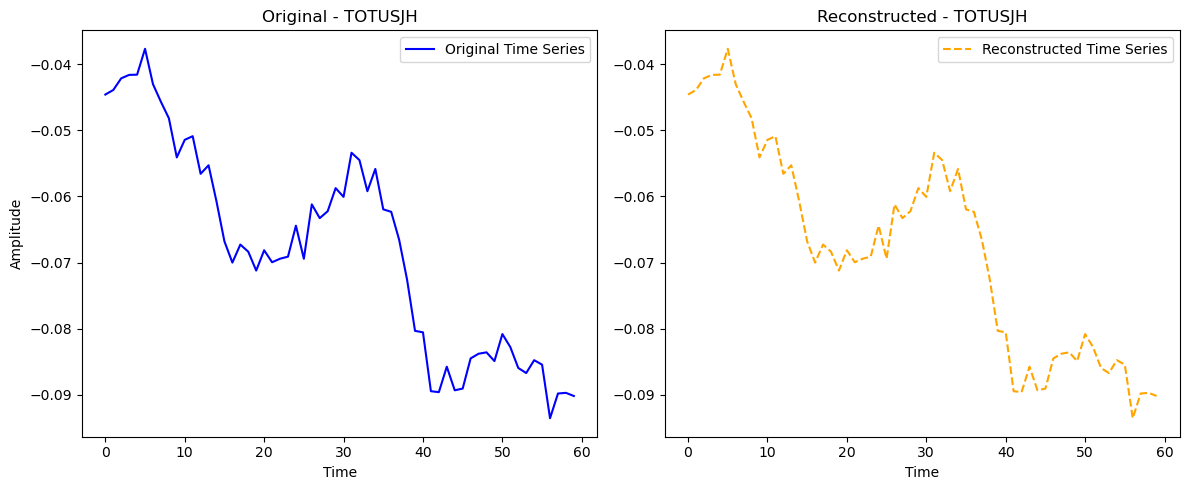

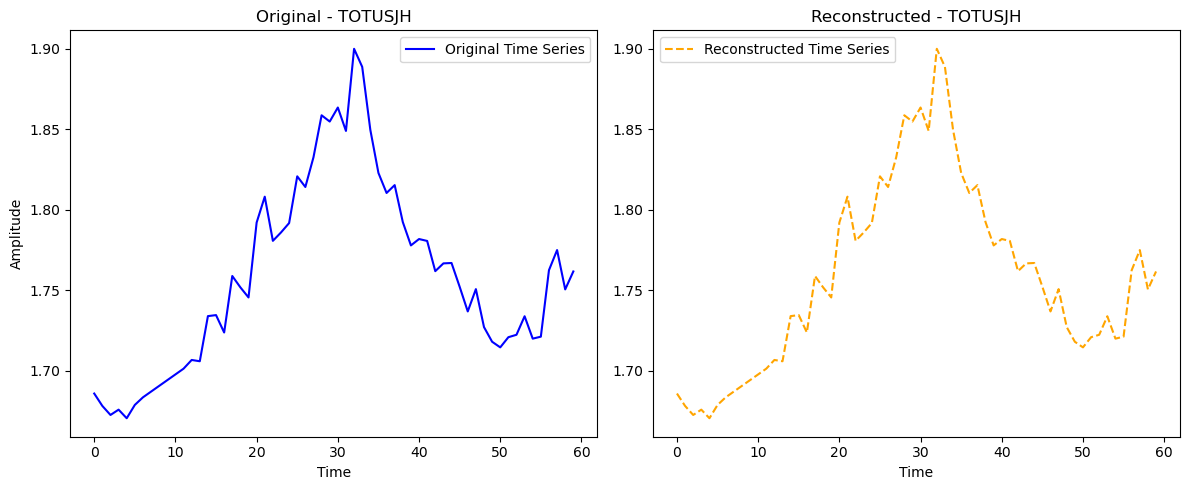

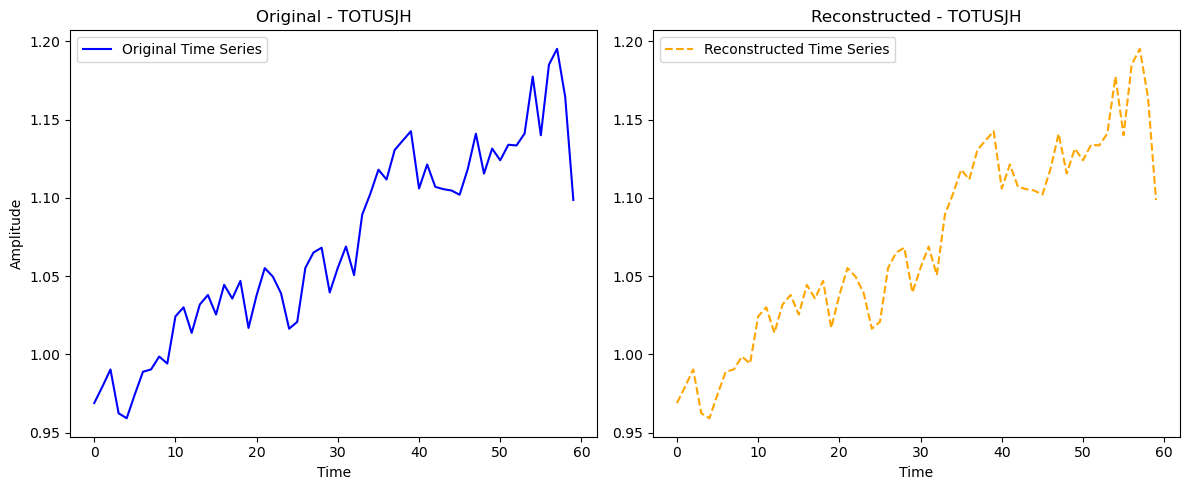

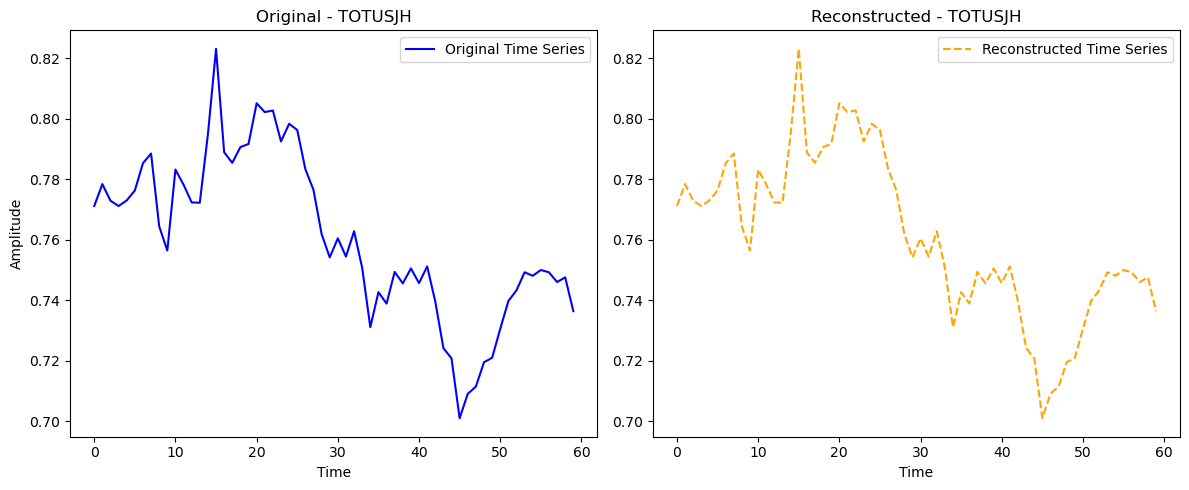

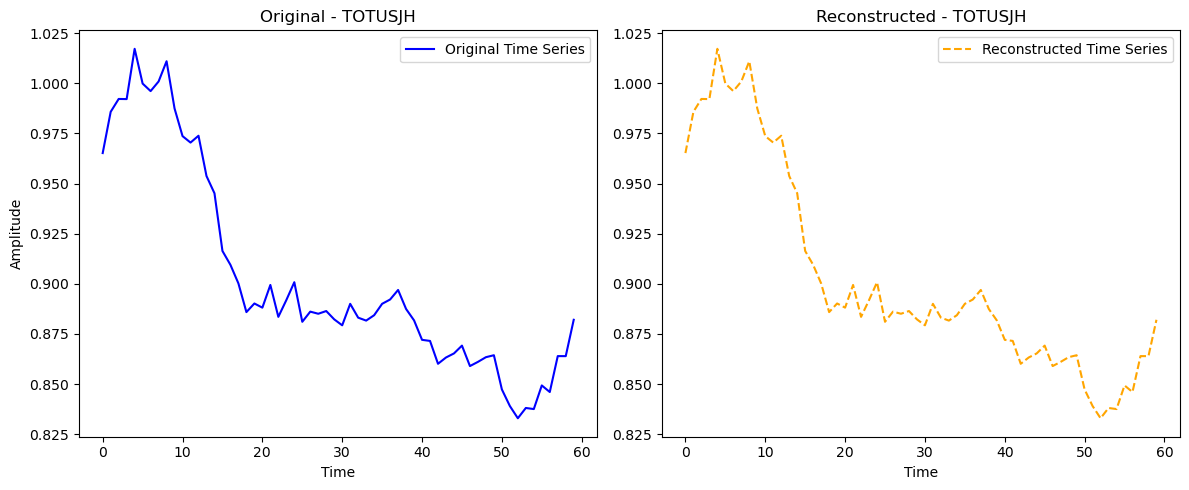

In [102]:
# Perform the DFT on the data
def apply_dft_to_dataset(dataset):
    # Apply DFT along the time axis (axis 1: timestamp axis)
    dft_data = np.fft.fft(dataset, axis=2)
    return dft_data

# Perform the IDFT to reconstruct the data without loss
def apply_idft_to_dataset(dft_data):
    # Apply IDFT along the time axis (axis 2: timestamp axis)
    reconstructed_data = np.fft.ifft(dft_data, axis=2).real  # Take the real part (remove small imaginary part)
    return reconstructed_data

# Visualization function for the first feature
def visualize_feature(original_data, reconstructed_data, feature_index):
    sample_index = 0  # Always use the first sample
    original_sample = original_data[sample_index, feature_index, :]
    reconstructed_sample = reconstructed_data[sample_index, feature_index, :]

    # Plot the original and reconstructed data for the first feature
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(original_sample, label='Original Time Series', color='blue')
    axes[0].set_title('Original - TOTUSJH')
    axes[0].legend()
    axes[0].set_ylabel('Amplitude')
    axes[0].set_xlabel('Time')

    axes[1].plot(reconstructed_sample, linestyle='--', label='Reconstructed Time Series', color='orange')
    axes[1].set_title('Reconstructed - TOTUSJH')
    axes[1].legend()
    axes[1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

# Main processing function for the dataset
def process_and_visualize(dataset, feature_index):
    # Step 1: Apply DFT to the dataset
    dft_data = apply_dft_to_dataset(dataset)
    
    # Step 2: Reconstruct the dataset by applying IDFT
    reconstructed_data = apply_idft_to_dataset(dft_data)
    
    # Step 3: Visualize the original and reconstructed data for the first feature
    visualize_feature(dataset, reconstructed_data, feature_index)

    return reconstructed_data
# Specify the feature index (0 for the first feature)
feature_index = 0

# Process and visualize the dataset
reconstructed_part1_dft_lossless = process_and_visualize(X_norm_part1, feature_index)
reconstructed_part2_dft_lossless = process_and_visualize(X_norm_part2, feature_index)
reconstructed_part3_dft_lossless = process_and_visualize(X_norm_part3, feature_index)
reconstructed_part4_dft_lossless = process_and_visualize(X_norm_part4, feature_index)
reconstructed_part5_dft_lossless = process_and_visualize(X_norm_part5, feature_index)


In [105]:
# Number of runs
n_runs = 10

# List to store scores for all partitions and runs
tss_scores_all_lossless = {2: [], 3: [], 4: [], 5: []}
hss_scores_all_lossless = {2: [], 3: [], 4: [], 5: []}

# Test partitions and corresponding labels
test_partitions = {
    2: (reconstructed_part2_dft_lossless, y_norm_part2),
    3: (reconstructed_part3_dft_lossless, y_norm_part3),
    4: (reconstructed_part4_dft_lossless, y_norm_part4),
    5: (reconstructed_part5_dft_lossless, y_norm_part5),
}

for run in range(n_runs):
    print(f"Run {run + 1}:")
    
    # Initialize the TimeSeriesForest classifier (ensure no fixed random_state for variability)
    tsf = MultivariateClassifier(TimeSeriesForest(
        max_depth=25, 
        min_window_size=1, 
        n_estimators=242, 
        n_windows=15, 
        min_samples_split=3, 
        min_samples_leaf=1, 
        criterion='entropy'
    ))
    
    # Fit the classifier on the training data
    tsf.fit(reconstructed_part1_dft_lossless, y_norm_part1)
    
    # Evaluate on each test partition
    for part_num, (X_test, y_test) in test_partitions.items():
        # Predict on the test data
        predictions = tsf.predict(X_test)
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test, predictions)
        
        # Extract values from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Compute TSS and HSS
        tss = (tp / (tp + fn)) - (fp / (fp + tn))
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        
        # Print scores for the current partition
        print(f"  Partition {part_num}: TSS: {tss:.2f}, HSS: {hss:.2f}")
        
        # Store scores
        tss_scores_all_lossless[part_num].append(tss)
        hss_scores_all_lossless[part_num].append(hss)


Run 1:
  Partition 2: TSS: 0.80, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 2:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 3:
  Partition 2: TSS: 0.80, HSS: 0.15
  Partition 3: TSS: 0.78, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 4:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 5:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 6:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 7:
  Partition 2: TSS: 0.81, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: 

In [106]:
mean_scores_lossless = {}

# Summarize results across runs for each partition
for part_num in test_partitions.keys():
    mean_tss_lossless = np.mean(tss_scores_all_lossless[part_num])
    mean_hss_lossless = np.mean(hss_scores_all_lossless[part_num])
    
    # Store the mean scores in the dictionary
    mean_scores_lossless[part_num] = {'mean_tss': mean_tss_lossless, 'mean_hss': mean_hss_lossless}
    
    print(f"\nPartition {part_num} Summary of Results:")
    print(f"  Average TSS: {mean_tss_lossless:.2f}")
    print(f"  Average HSS: {mean_hss_lossless:.2f}")


Partition 2 Summary of Results:
  Average TSS: 0.81
  Average HSS: 0.15

Partition 3 Summary of Results:
  Average TSS: 0.77
  Average HSS: 0.22

Partition 4 Summary of Results:
  Average TSS: 0.82
  Average HSS: 0.20

Partition 5 Summary of Results:
  Average TSS: 0.88
  Average HSS: 0.18


In [107]:
# Initialize variables for each partition
mean_tss_lossless_part2 = mean_scores_lossless[2]['mean_tss']
mean_hss_lossless_part2 = mean_scores_lossless[2]['mean_hss']

mean_tss_lossless_part3 = mean_scores_lossless[3]['mean_tss']
mean_hss_lossless_part3 = mean_scores_lossless[3]['mean_hss']

mean_tss_lossless_part4 = mean_scores_lossless[4]['mean_tss']
mean_hss_lossless_part4 = mean_scores_lossless[4]['mean_hss']

mean_tss_lossless_part5 = mean_scores_lossless[5]['mean_tss']
mean_hss_lossless_part5 = mean_scores_lossless[5]['mean_hss']

# Print to verify
print(f"Partition 2: Mean TSS = {mean_tss_lossless_part2:.2f}, Mean HSS = {mean_hss_lossless_part2:.2f}")
print(f"Partition 3: Mean TSS = {mean_tss_lossless_part3:.2f}, Mean HSS = {mean_hss_lossless_part3:.2f}")
print(f"Partition 4: Mean TSS = {mean_tss_lossless_part4:.2f}, Mean HSS = {mean_hss_lossless_part4:.2f}")
print(f"Partition 5: Mean TSS = {mean_tss_lossless_part5:.2f}, Mean HSS = {mean_hss_lossless_part5:.2f}")


Partition 2: Mean TSS = 0.81, Mean HSS = 0.15
Partition 3: Mean TSS = 0.77, Mean HSS = 0.22
Partition 4: Mean TSS = 0.82, Mean HSS = 0.20
Partition 5: Mean TSS = 0.88, Mean HSS = 0.18


### DFT Lossy

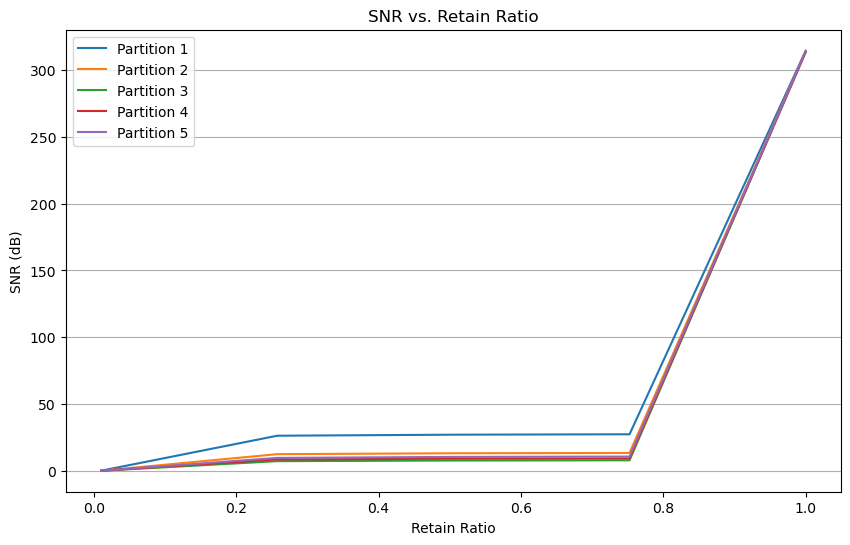

In [152]:

def apply_dft_to_dataset(dataset):
    """Perform DFT on the dataset along the time axis (axis 2)."""
    dft_data = np.fft.fft(dataset, axis=2)
    return dft_data

def apply_filtered_idft(dft_data, retain_ratio):
    """Perform lossy IDFT by applying a low-pass filter based on the retain ratio."""
    num_samples, num_features, num_timestamps = dft_data.shape
    retain_count = int(retain_ratio * num_timestamps)
    
    # Create a mask to keep only the low frequencies
    mask = np.zeros_like(dft_data, dtype=bool)
    mask[:, :, :retain_count] = True  # Retain the first `retain_count` frequencies
    
    # Apply the mask to retain only the low frequencies
    filtered_dft_data = np.where(mask, dft_data, 0)
    
    # Reconstruct the signal using the inverse DFT
    reconstructed_data = np.fft.ifft(filtered_dft_data, axis=2).real
    return reconstructed_data

def compute_snr(original_data, reconstructed_data):
    """
    Compute Signal-to-Noise Ratio (SNR) between the original and reconstructed data.
    Higher values indicate better preservation of the original signal.
    """
    signal_power = np.sum(original_data**2)
    noise_power = np.sum((original_data - reconstructed_data)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def process_dataset_for_snr(dataset, retain_ratios):
    """
    Process a dataset and compute SNR for a range of retain ratios.
    """
    dft_data = apply_dft_to_dataset(dataset)
    snr_values = []
    for ratio in retain_ratios:
        reconstructed_data = apply_filtered_idft(dft_data, ratio)
        snr = compute_snr(dataset, reconstructed_data)
        snr_values.append(snr)
    return snr_values

# Specify a range of retain ratios to evaluate
retain_ratios = np.linspace(0.01, 1.0, 5)  # 1% to 100% retain ratio

# Compute SNR values for each dataset and retain ratio
snr_part1 = process_dataset_for_snr(X_norm_part1, retain_ratios)
snr_part2 = process_dataset_for_snr(X_norm_part2, retain_ratios)
snr_part3 = process_dataset_for_snr(X_norm_part3, retain_ratios)
snr_part4 = process_dataset_for_snr(X_norm_part4, retain_ratios)
snr_part5 = process_dataset_for_snr(X_norm_part5, retain_ratios)

# Plot SNR vs. retain ratio
plt.figure(figsize=(10, 6))
plt.plot(retain_ratios, snr_part1, label='Partition 1')
plt.plot(retain_ratios, snr_part2, label='Partition 2')
plt.plot(retain_ratios, snr_part3, label='Partition 3')
plt.plot(retain_ratios, snr_part4, label='Partition 4')
plt.plot(retain_ratios, snr_part5, label='Partition 5')

plt.title('SNR vs. Retain Ratio')
plt.xlabel('Retain Ratio')
plt.ylabel('SNR (dB)')
plt.legend()
plt.grid(axis='y')  # Horizontal grid lines only
plt.savefig('yourlocation')
plt.show()


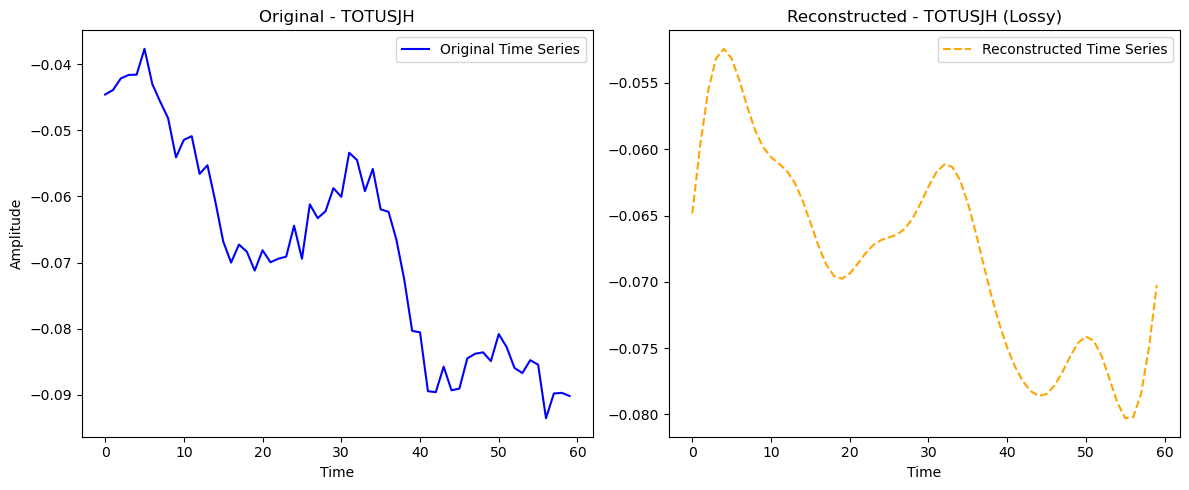

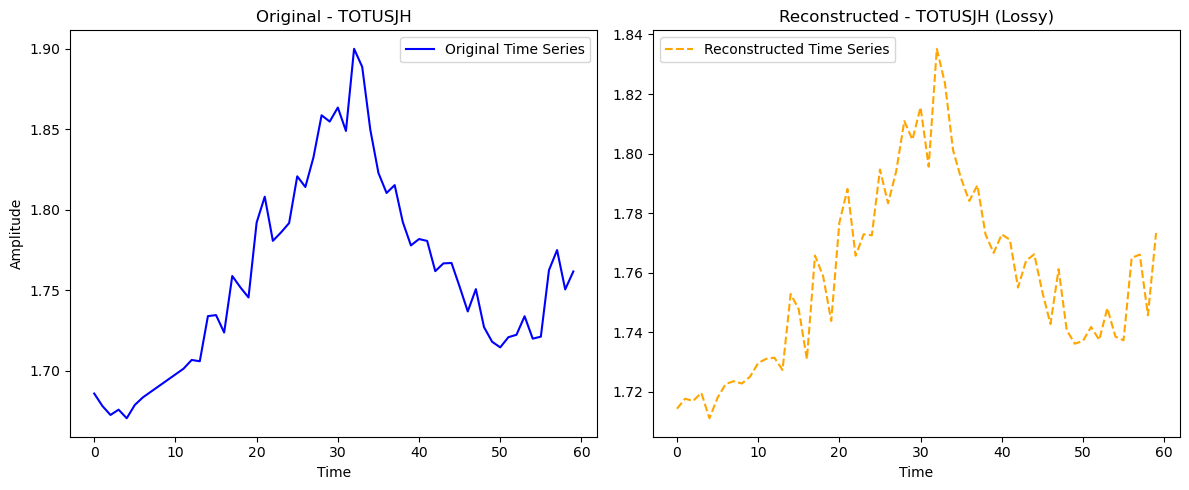

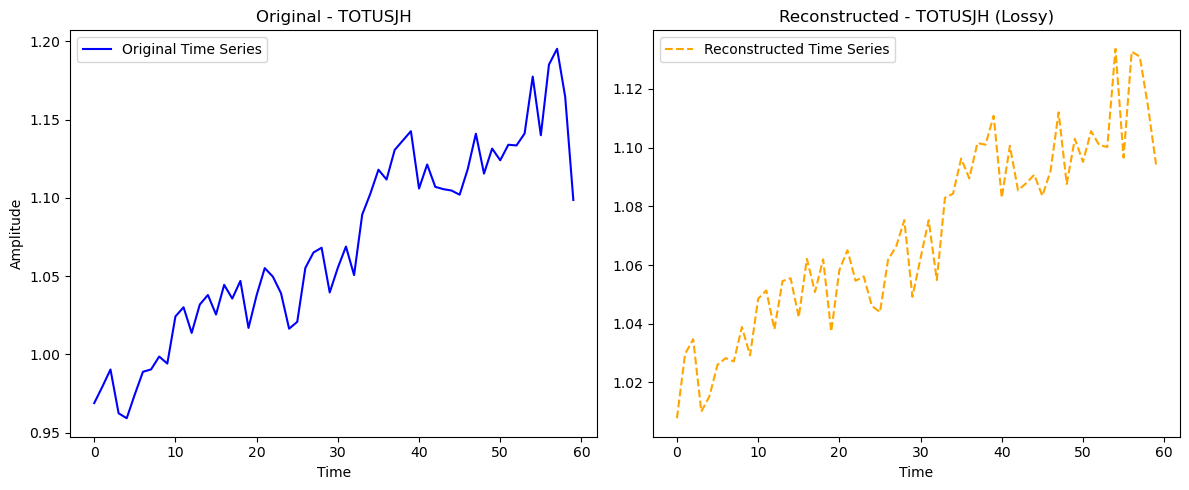

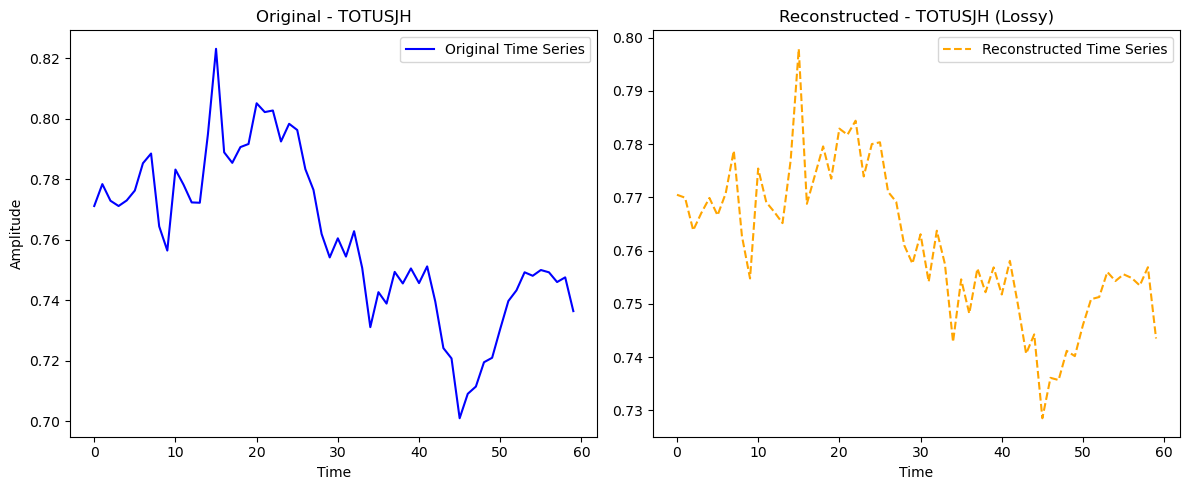

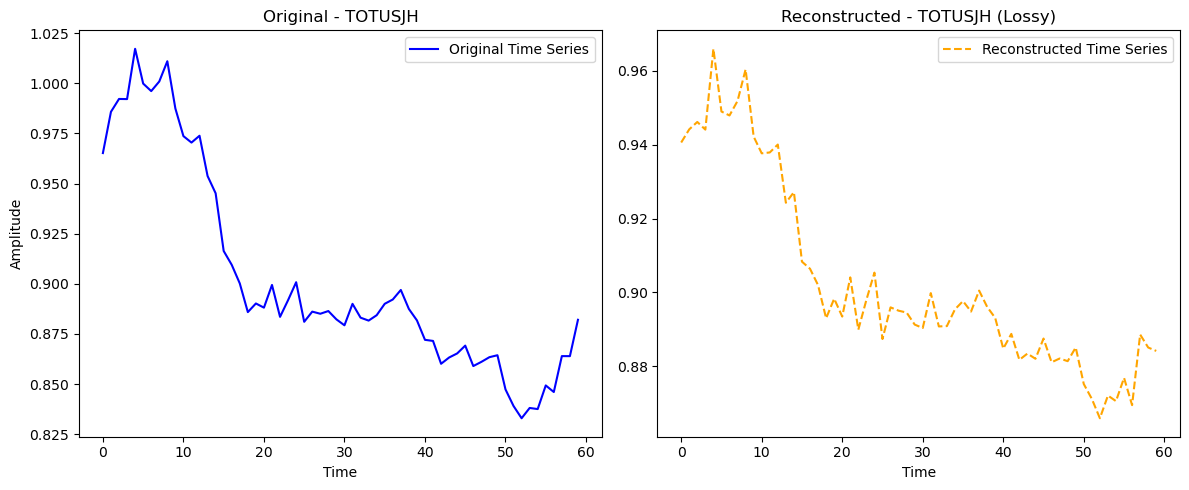

In [153]:

def visualize_feature(original_data, reconstructed_data, feature_index):
    """
    Visualize the original and reconstructed data for the first feature.
    """
    sample_index = 0  # Always use the first sample
    original_sample = original_data[sample_index, feature_index, :]
    reconstructed_sample = reconstructed_data[sample_index, feature_index, :]

    # Plot the original and reconstructed data for the first feature
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(original_sample, label='Original Time Series', color='blue')
    axes[0].set_title('Original - TOTUSJH')
    axes[0].legend()
    axes[0].set_ylabel('Amplitude')
    axes[0].set_xlabel('Time')

    axes[1].plot(reconstructed_sample, linestyle='--', label='Reconstructed Time Series', color='orange')
    axes[1].set_title('Reconstructed - TOTUSJH (Lossy)')
    axes[1].legend()
    axes[1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

# Main processing function
def process_and_visualize(dataset, feature_index, retain_ratio):
    # Step 1: Apply DFT
    dft_data = apply_dft_to_dataset(dataset)
    
    # Step 2: Reconstruct with filtered frequencies
    reconstructed_data = apply_filtered_idft(dft_data, retain_ratio)
    
    # Step 3: Visualize
    visualize_feature(dataset, reconstructed_data, feature_index)
    
    return reconstructed_data

# Example Usage
feature_index = 0  # First feature
retain_ratio = 0.75  # Retain top 70% of frequencies

reconstructed_part1_dft_lossy = process_and_visualize(X_norm_part1, feature_index, retain_ratio=0.12)
reconstructed_part2_dft_lossy = process_and_visualize(X_norm_part2, feature_index, retain_ratio)
reconstructed_part3_dft_lossy = process_and_visualize(X_norm_part3, feature_index, retain_ratio)
reconstructed_part4_dft_lossy = process_and_visualize(X_norm_part4, feature_index, retain_ratio)
reconstructed_part5_dft_lossy = process_and_visualize(X_norm_part5, feature_index, retain_ratio)


In [154]:
# Number of runs
n_runs = 10

# List to store scores for all partitions and runs
tss_scores_all_lossy = {2: [], 3: [], 4: [], 5: []}
hss_scores_all_lossy = {2: [], 3: [], 4: [], 5: []}

# Test partitions and corresponding labels
test_partitions = {
    2: (reconstructed_part2_dft_lossy, y_norm_part2),
    3: (reconstructed_part3_dft_lossy, y_norm_part3),
    4: (reconstructed_part4_dft_lossy, y_norm_part4),
    5: (reconstructed_part5_dft_lossy, y_norm_part5),
}

for run in range(n_runs):
    print(f"Run {run + 1}:")
    
    # Initialize the TimeSeriesForest classifier (ensure no fixed random_state for variability)
    tsf = MultivariateClassifier(TimeSeriesForest(
        max_depth=25, 
        min_window_size=1, 
        n_estimators=242, 
        n_windows=15, 
        min_samples_split=3, 
        min_samples_leaf=1, 
        criterion='entropy'
    ))
    
    # Fit the classifier on the training data
    tsf.fit(reconstructed_part1_dft_lossy, y_norm_part1)
    
    # Evaluate on each test partition
    for part_num, (X_test, y_test) in test_partitions.items():
        # Predict on the test data
        predictions = tsf.predict(X_test)
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test, predictions)
        
        # Extract values from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Compute TSS and HSS
        tss = (tp / (tp + fn)) - (fp / (fp + tn))
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        
        # Print scores for the current partition
        print(f"  Partition {part_num}: TSS: {tss:.2f}, HSS: {hss:.2f}")
        
        # Store scores
        tss_scores_all_lossy[part_num].append(tss)
        hss_scores_all_lossy[part_num].append(hss)


Run 1:
  Partition 2: TSS: 0.81, HSS: 0.14
  Partition 3: TSS: 0.76, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 2:
  Partition 2: TSS: 0.80, HSS: 0.14
  Partition 3: TSS: 0.77, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 3:
  Partition 2: TSS: 0.80, HSS: 0.14
  Partition 3: TSS: 0.77, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 4:
  Partition 2: TSS: 0.81, HSS: 0.14
  Partition 3: TSS: 0.76, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 5:
  Partition 2: TSS: 0.81, HSS: 0.14
  Partition 3: TSS: 0.77, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 6:
  Partition 2: TSS: 0.81, HSS: 0.14
  Partition 3: TSS: 0.77, HSS: 0.20
  Partition 4: TSS: 0.81, HSS: 0.18
  Partition 5: TSS: 0.87, HSS: 0.16
Run 7:
  Partition 2: TSS: 0.80, HSS: 0.14
  Partition 3: TSS: 0.76, HSS: 0.20
  Partition 4: 

In [155]:
mean_scores_lossy = {}

# Summarize results across runs for each partition
for part_num in test_partitions.keys():
    mean_tss_lossy = np.mean(tss_scores_all_lossy[part_num])
    mean_hss_lossy = np.mean(hss_scores_all_lossy[part_num])
    
    # Store the mean scores in the dictionary
    mean_scores_lossy[part_num] = {'mean_tss': mean_tss_lossy, 'mean_hss': mean_hss_lossy}
    
    print(f"\nPartition {part_num} Summary of Results:")
    print(f"  Average TSS: {mean_tss_lossy:.2f}")
    print(f"  Average HSS: {mean_hss_lossy:.2f}")


Partition 2 Summary of Results:
  Average TSS: 0.80
  Average HSS: 0.14

Partition 3 Summary of Results:
  Average TSS: 0.77
  Average HSS: 0.20

Partition 4 Summary of Results:
  Average TSS: 0.81
  Average HSS: 0.18

Partition 5 Summary of Results:
  Average TSS: 0.87
  Average HSS: 0.16


In [156]:
# Initialize variables for each partition
mean_tss_lossy_part2 = mean_scores_lossy[2]['mean_tss']
mean_hss_lossy_part2 = mean_scores_lossy[2]['mean_hss']

mean_tss_lossy_part3 = mean_scores_lossy[3]['mean_tss']
mean_hss_lossy_part3 = mean_scores_lossy[3]['mean_hss']

mean_tss_lossy_part4 = mean_scores_lossy[4]['mean_tss']
mean_hss_lossy_part4 = mean_scores_lossy[4]['mean_hss']

mean_tss_lossy_part5 = mean_scores_lossy[5]['mean_tss']
mean_hss_lossy_part5 = mean_scores_lossy[5]['mean_hss']

# Print to verify
print(f"Partition 2: Mean TSS = {mean_tss_lossy_part2:.2f}, Mean HSS = {mean_hss_lossy_part2:.2f}")
print(f"Partition 3: Mean TSS = {mean_tss_lossy_part3:.2f}, Mean HSS = {mean_hss_lossy_part3:.2f}")
print(f"Partition 4: Mean TSS = {mean_tss_lossy_part4:.2f}, Mean HSS = {mean_hss_lossy_part4:.2f}")
print(f"Partition 5: Mean TSS = {mean_tss_lossy_part5:.2f}, Mean HSS = {mean_hss_lossy_part5:.2f}")


Partition 2: Mean TSS = 0.80, Mean HSS = 0.14
Partition 3: Mean TSS = 0.77, Mean HSS = 0.20
Partition 4: Mean TSS = 0.81, Mean HSS = 0.18
Partition 5: Mean TSS = 0.87, Mean HSS = 0.16


### HAAR LOSSY

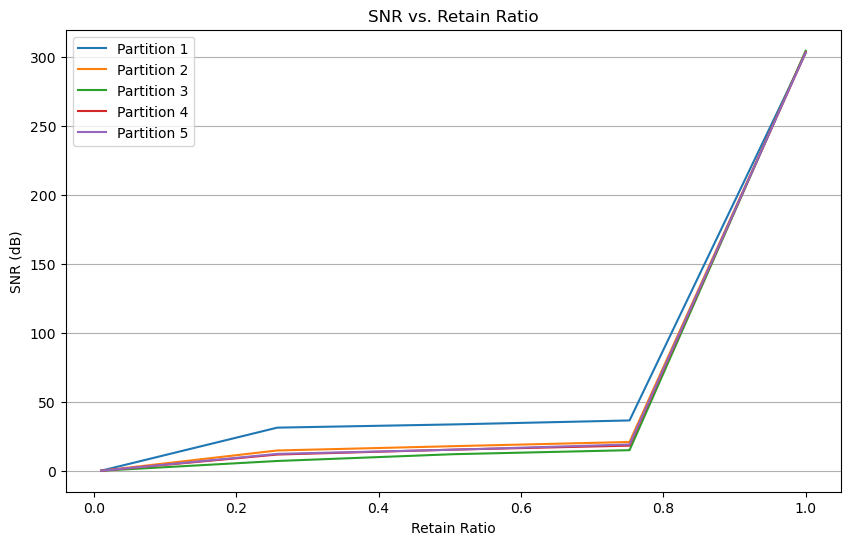

In [157]:
def apply_hwt_to_dataset(dataset):
    """Perform Haar Wavelet Transform (HWT) on the dataset along the time axis (axis 2)."""
    transformed_data = []
    coeff_slices = []
    for sample in dataset:
        transformed_sample = []
        slices = []
        for feature in sample:
            coeffs, slice_info = pywt.coeffs_to_array(pywt.wavedec(feature, wavelet='haar'))
            transformed_sample.append(coeffs)
            slices.append(slice_info)
        transformed_data.append(transformed_sample)
        coeff_slices.append(slices)
    return np.array(transformed_data), coeff_slices

def apply_filtered_iwt(transformed_data, coeff_slices, retain_ratio):
    """Perform lossy inverse Haar Wavelet Transform (IWT) by applying a low-pass filter based on the retain ratio."""
    reconstructed_data = []
    for transformed_sample, sample_slices in zip(transformed_data, coeff_slices):
        reconstructed_sample = []
        for coeffs, slice_info in zip(transformed_sample, sample_slices):
            retain_count = int(len(coeffs) * retain_ratio)
            filtered_coeffs = np.zeros_like(coeffs)
            filtered_coeffs[:retain_count] = coeffs[:retain_count]
            reconstructed_signal = pywt.waverec(pywt.array_to_coeffs(filtered_coeffs, slice_info, output_format='wavedec'), wavelet='haar')
            reconstructed_sample.append(reconstructed_signal[:len(coeffs)])  # Truncate to original length
        reconstructed_data.append(reconstructed_sample)
    return np.array(reconstructed_data)

def compute_snr(original_data, reconstructed_data):
    """
    Compute Signal-to-Noise Ratio (SNR) between the original and reconstructed data.
    Higher values indicate better preservation of the original signal.
    """
    signal_power = np.sum(original_data**2)
    noise_power = np.sum((original_data - reconstructed_data)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def process_dataset_for_snr(dataset, retain_ratios):
    """
    Process a dataset and compute SNR for a range of retain ratios using Haar Wavelet Transform.
    """
    transformed_data, coeff_slices = apply_hwt_to_dataset(dataset)
    snr_values = []
    for ratio in retain_ratios:
        reconstructed_data = apply_filtered_iwt(transformed_data, coeff_slices, ratio)
        snr = compute_snr(dataset, reconstructed_data)
        snr_values.append(snr)
    return snr_values

# Specify a range of retain ratios to evaluate
retain_ratios = np.linspace(0.01, 1.0, 5)  # 1% to 100% retain ratio

# Compute SNR values for each dataset and retain ratio
snr_part1 = process_dataset_for_snr(X_norm_part1, retain_ratios)
snr_part2 = process_dataset_for_snr(X_norm_part2, retain_ratios)
snr_part3 = process_dataset_for_snr(X_norm_part3, retain_ratios)
snr_part4 = process_dataset_for_snr(X_norm_part4, retain_ratios)
snr_part5 = process_dataset_for_snr(X_norm_part5, retain_ratios)

# Plot SNR vs. retain ratio
plt.figure(figsize=(10, 6))
plt.plot(retain_ratios, snr_part1, label='Partition 1')
plt.plot(retain_ratios, snr_part2, label='Partition 2')
plt.plot(retain_ratios, snr_part3, label='Partition 3')
plt.plot(retain_ratios, snr_part4, label='Partition 4')
plt.plot(retain_ratios, snr_part5, label='Partition 5')

plt.title('SNR vs. Retain Ratio')
plt.xlabel('Retain Ratio')
plt.ylabel('SNR (dB)')
plt.legend()
plt.grid(axis='y')  # Horizontal grid lines only
plt.savefig('yourlocation')
plt.show()


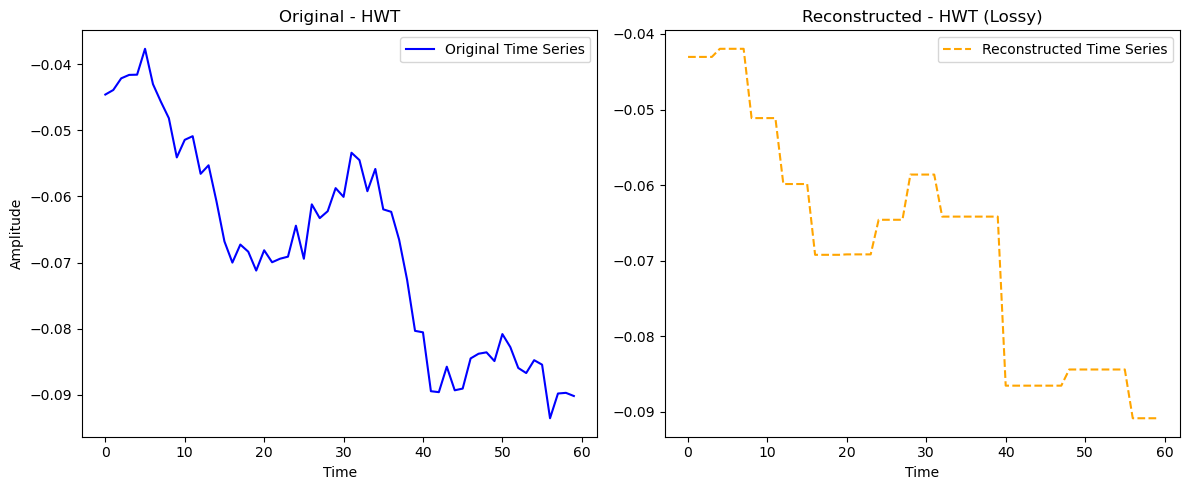

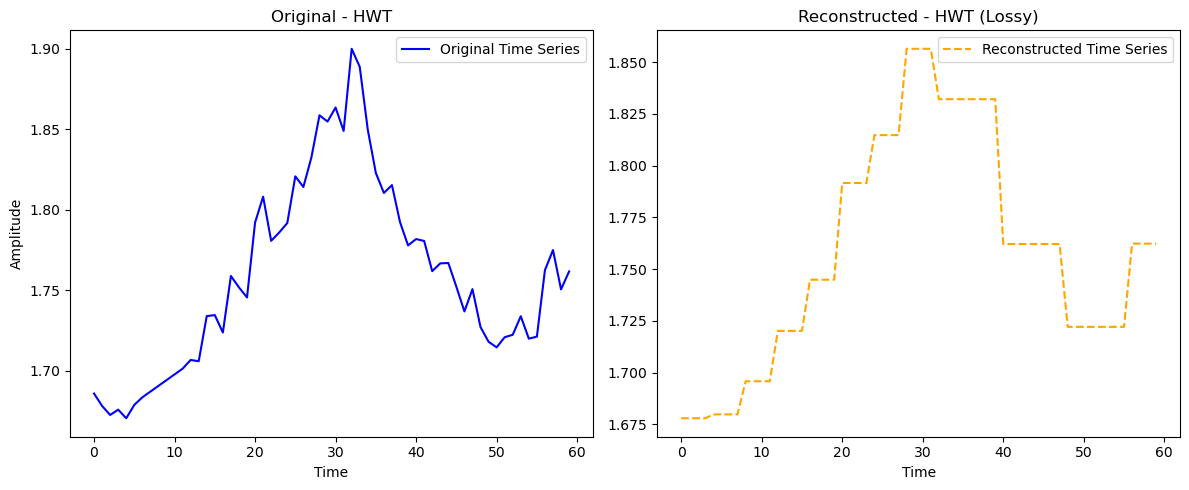

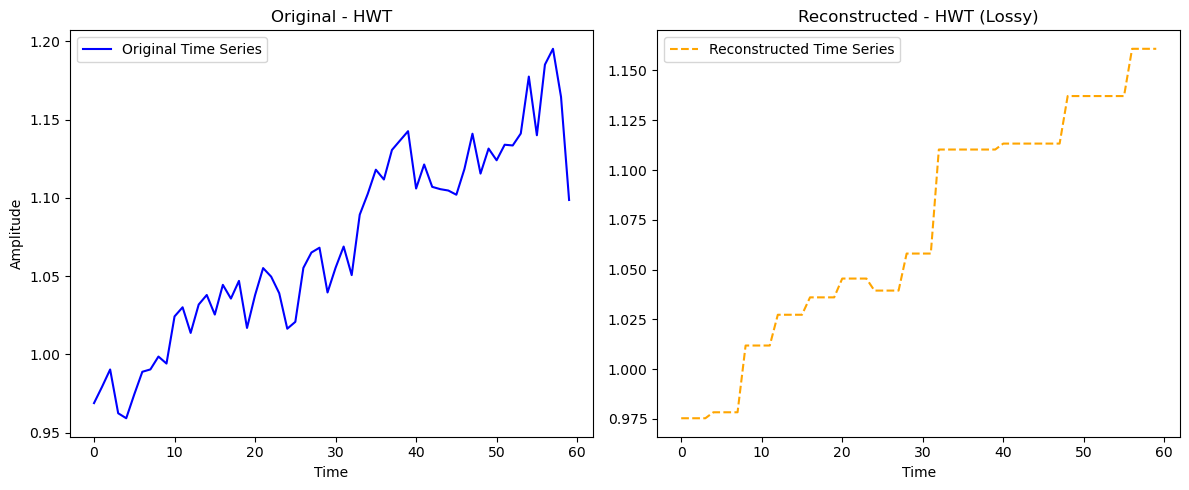

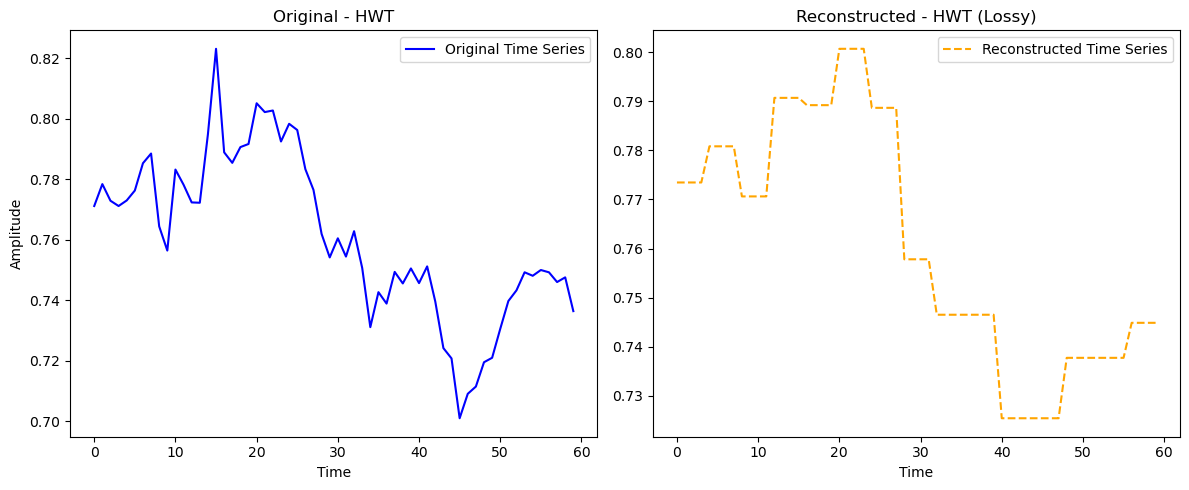

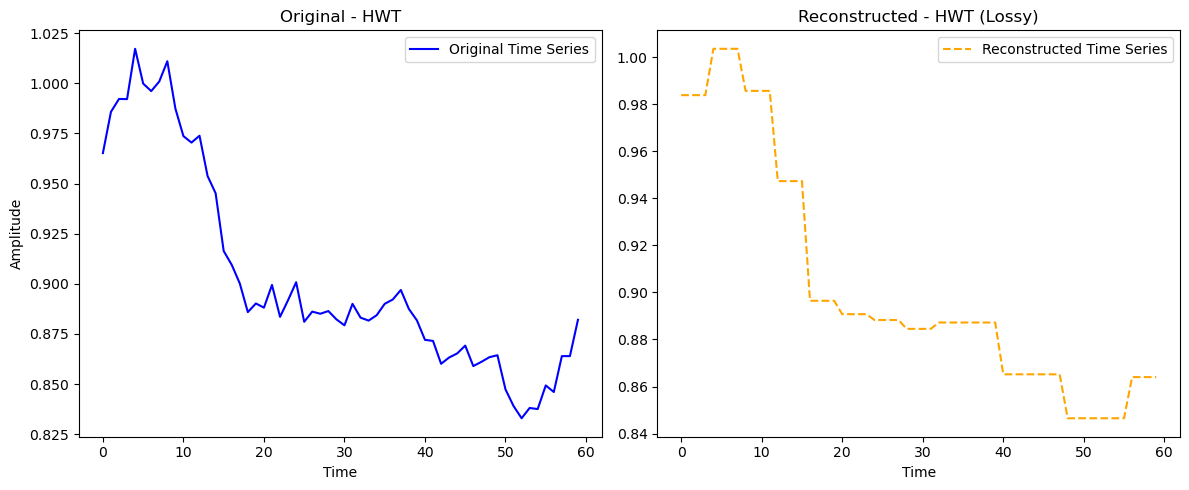

In [163]:
def visualize_feature_hwt(original_data, reconstructed_data, feature_index, sample_index=0):
    """
    Visualize the original and reconstructed data for the first feature using HWT.
    """
    original_sample = original_data[sample_index, feature_index, :]
    reconstructed_sample = reconstructed_data[sample_index, feature_index, :]

    # Plot the original and reconstructed data for the first feature
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(original_sample, label='Original Time Series', color='blue')
    axes[0].set_title('Original - HWT')
    axes[0].legend()
    axes[0].set_ylabel('Amplitude')
    axes[0].set_xlabel('Time')

    axes[1].plot(reconstructed_sample, linestyle='--', label='Reconstructed Time Series', color='orange')
    axes[1].set_title('Reconstructed - HWT (Lossy)')
    axes[1].legend()
    axes[1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

# Main processing function for HWT
def process_and_visualize_hwt(dataset, feature_index, retain_ratio, sample_index=0):
    # Step 1: Apply HWT to the dataset
    transformed_data, coeff_slices = apply_hwt_to_dataset(dataset)
    
    # Step 2: Perform inverse HWT with filtered coefficients based on retain ratio
    reconstructed_data = apply_filtered_iwt(transformed_data, coeff_slices, retain_ratio)
    
    # Step 3: Visualize the feature
    visualize_feature_hwt(dataset, reconstructed_data, feature_index, sample_index)
    
    return reconstructed_data

# Example Usage
feature_index = 0  # First feature
retain_ratio = 0.2  # Retain top 75% of coefficients

# Process and visualize for each partition
reconstructed_part1_hwt_lossy = process_and_visualize_hwt(X_norm_part1, feature_index, retain_ratio)
reconstructed_part2_hwt_lossy = process_and_visualize_hwt(X_norm_part2, feature_index, retain_ratio)
reconstructed_part3_hwt_lossy = process_and_visualize_hwt(X_norm_part3, feature_index, retain_ratio)
reconstructed_part4_hwt_lossy = process_and_visualize_hwt(X_norm_part4, feature_index, retain_ratio)
reconstructed_part5_hwt_lossy = process_and_visualize_hwt(X_norm_part5, feature_index, retain_ratio)


In [164]:
# Number of runs
n_runs = 10

# List to store scores for all partitions and runs
tss_scores_all_hwt_lossy = {2: [], 3: [], 4: [], 5: []}
hss_scores_all_hwt_lossy = {2: [], 3: [], 4: [], 5: []}

# Test partitions and corresponding labels
test_partitions = {
    2: (reconstructed_part2_hwt_lossy, y_norm_part2),
    3: (reconstructed_part3_hwt_lossy, y_norm_part3),
    4: (reconstructed_part4_hwt_lossy, y_norm_part4),
    5: (reconstructed_part5_hwt_lossy, y_norm_part5),
}

for run in range(n_runs):
    print(f"Run {run + 1}:")
    
    # Initialize the TimeSeriesForest classifier (ensure no fixed random_state for variability)
    tsf = MultivariateClassifier(TimeSeriesForest(
        max_depth=25, 
        min_window_size=1, 
        n_estimators=242, 
        n_windows=15, 
        min_samples_split=3, 
        min_samples_leaf=1, 
        criterion='entropy'
    ))
    
    # Fit the classifier on the training data
    tsf.fit(reconstructed_part1_hwt_lossy, y_norm_part1)
    
    # Evaluate on each test partition
    for part_num, (X_test, y_test) in test_partitions.items():
        # Predict on the test data
        predictions = tsf.predict(X_test)
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test, predictions)
        
        # Extract values from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        
        # Compute TSS and HSS
        tss = (tp / (tp + fn)) - (fp / (fp + tn))
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        
        # Print scores for the current partition
        print(f"  Partition {part_num}: TSS: {tss:.2f}, HSS: {hss:.2f}")
        
        # Store scores
        tss_scores_all_hwt_lossy[part_num].append(tss)
        hss_scores_all_hwt_lossy[part_num].append(hss)


Run 1:
  Partition 2: TSS: 0.81, HSS: 0.16
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 2:
  Partition 2: TSS: 0.80, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 3:
  Partition 2: TSS: 0.81, HSS: 0.16
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 4:
  Partition 2: TSS: 0.80, HSS: 0.16
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 5:
  Partition 2: TSS: 0.80, HSS: 0.15
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.88, HSS: 0.18
Run 6:
  Partition 2: TSS: 0.81, HSS: 0.16
  Partition 3: TSS: 0.77, HSS: 0.22
  Partition 4: TSS: 0.82, HSS: 0.20
  Partition 5: TSS: 0.87, HSS: 0.18
Run 7:
  Partition 2: TSS: 0.81, HSS: 0.16
  Partition 3: TSS: 0.76, HSS: 0.22
  Partition 4: 

In [167]:
mean_scores_hwt_lossy = {}

# Summarize results across runs for each partition
for part_num in test_partitions.keys():
    mean_tss_hwt_lossy = np.mean(tss_scores_all_hwt_lossy[part_num])
    mean_hss_hwt_lossy = np.mean(hss_scores_all_hwt_lossy[part_num])
    
    # Store the mean scores in the dictionary
    mean_scores_hwt_lossy[part_num] = {'mean_tss': mean_tss_hwt_lossy, 'mean_hss': mean_hss_hwt_lossy}
    
    print(f"\nPartition {part_num} Summary of Results:")
    print(f"  Average TSS: {mean_tss_hwt_lossy:.2f}")
    print(f"  Average HSS: {mean_hss_hwt_lossy:.2f}")


Partition 2 Summary of Results:
  Average TSS: 0.81
  Average HSS: 0.16

Partition 3 Summary of Results:
  Average TSS: 0.77
  Average HSS: 0.22

Partition 4 Summary of Results:
  Average TSS: 0.82
  Average HSS: 0.20

Partition 5 Summary of Results:
  Average TSS: 0.88
  Average HSS: 0.18


In [166]:
# Initialize variables for each partition
mean_tss_lossy_hwt_part2 = mean_scores_hwt_lossy[2]['mean_tss']
mean_hss_lossy_hwt_part2 = mean_scores_hwt_lossy[2]['mean_hss']

mean_tss_lossy_hwt_part3 = mean_scores_hwt_lossy[3]['mean_tss']
mean_hss_lossy_hwt_part3 = mean_scores_hwt_lossy[3]['mean_hss']

mean_tss_lossy_hwt_part4 = mean_scores_hwt_lossy[4]['mean_tss']
mean_hss_lossy_hwt_part4 = mean_scores_hwt_lossy[4]['mean_hss']

mean_tss_lossy_hwt_part5 = mean_scores_hwt_lossy[5]['mean_tss']
mean_hss_lossy_hwt_part5 = mean_scores_hwt_lossy[5]['mean_hss']

# Print to verify
print(f"Partition 2: Mean TSS = {mean_tss_lossy_hwt_part2:.2f}, Mean HSS = {mean_hss_lossy_hwt_part2:.2f}")
print(f"Partition 3: Mean TSS = {mean_tss_lossy_hwt_part3:.2f}, Mean HSS = {mean_hss_lossy_hwt_part3:.2f}")
print(f"Partition 4: Mean TSS = {mean_tss_lossy_hwt_part4:.2f}, Mean HSS = {mean_hss_lossy_hwt_part4:.2f}")
print(f"Partition 5: Mean TSS = {mean_tss_lossy_hwt_part5:.2f}, Mean HSS = {mean_hss_lossy_hwt_part5:.2f}")


Partition 2: Mean TSS = 0.81, Mean HSS = 0.16
Partition 3: Mean TSS = 0.77, Mean HSS = 0.22
Partition 4: Mean TSS = 0.82, Mean HSS = 0.20
Partition 5: Mean TSS = 0.88, Mean HSS = 0.18


### DAUBECHIES LOSSY

In [ ]:
def apply_wavelet_transform_to_dataset(dataset, wavelet='db1', level=3):
    """Perform Daubechies wavelet transform on the dataset along the time axis (axis 2)."""
    wavelet_data = np.empty((dataset.shape[0], dataset.shape[1]), dtype=object)  # Store as objects (list of arrays)
    
    for i in range(dataset.shape[0]):  # Loop over all samples
        for j in range(dataset.shape[1]):  # Loop over all features
            coeffs = pywt.wavedec(dataset[i, j, :], wavelet, level=level)
            wavelet_data[i, j] = coeffs  # Store the list of coefficients
    
    return wavelet_data

def apply_filtered_wavelet_reconstruction(wavelet_data, retain_ratio, wavelet='db1'):
    """Perform lossy wavelet reconstruction by applying a low-pass filter based on the retain ratio."""
    num_samples, num_features = wavelet_data.shape  # Removed the third dimension
    filtered_wavelet_data = np.zeros_like(wavelet_data, dtype=object)
    
    for i in range(num_samples):
        for j in range(num_features):
            coeffs = wavelet_data[i, j]
            # Number of coefficients to retain (only approximation coefficients)
            approx_coeffs = coeffs[0]
            retain_count = int(len(approx_coeffs) * retain_ratio)
            coeffs[0] = approx_coeffs[:retain_count]  # Keep the low frequencies
            
            # Zero out detail coefficients (high frequencies)
            for k in range(1, len(coeffs)):  # Starting from 1 to skip approximation coefficients
                coeffs[k] = np.zeros_like(coeffs[k])  # Zero out the high-frequency components
            
            # Ensure the coefficient list has the correct length for reconstruction
            # This step ensures that the length of coeffs is consistent for reconstruction
            if len(coeffs) < 4:  # If there are fewer than 4 levels of coefficients, fill the rest with empty arrays
                coeffs.extend([np.zeros_like(coeffs[0])] * (4 - len(coeffs)))
            
            # Reconstruct the signal using the inverse wavelet transform
            filtered_wavelet_data[i, j] = pywt.waverec(coeffs, wavelet)
    
    return filtered_wavelet_data
   
    
def compute_snr(original_data, reconstructed_data):
    """
    Compute Signal-to-Noise Ratio (SNR) between the original and reconstructed data.
    Higher values indicate better preservation of the original signal.
    """
    signal_power = np.sum(original_data**2)
    noise_power = np.sum((original_data - reconstructed_data)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def process_dataset_for_snr(dataset, retain_ratios, wavelet='db1', level=3):
    """
    Process a dataset and compute SNR for a range of retain ratios using Daubechies wavelet transform.
    """
    wavelet_data = apply_wavelet_transform_to_dataset(dataset, wavelet, level)
    snr_values = []
    for ratio in retain_ratios:
        reconstructed_data = apply_filtered_wavelet_reconstruction(wavelet_data, ratio, wavelet)
        snr = compute_snr(dataset, reconstructed_data)
        snr_values.append(snr)
    return snr_values

# Specify a range of retain ratios to evaluate
retain_ratios = np.linspace(0.01, 1.0, 5)  # 1% to 100% retain ratio

# Compute SNR values for each dataset and retain ratio
snr_part1 = process_dataset_for_snr(X_norm_part1, retain_ratios, wavelet='db1', level=3)
snr_part2 = process_dataset_for_snr(X_norm_part2, retain_ratios, wavelet='db1', level=3)
snr_part3 = process_dataset_for_snr(X_norm_part3, retain_ratios, wavelet='db1', level=3)
snr_part4 = process_dataset_for_snr(X_norm_part4, retain_ratios, wavelet='db1', level=3)
snr_part5 = process_dataset_for_snr(X_norm_part5, retain_ratios, wavelet='db1', level=3)

# Plot SNR vs. retain ratio
plt.figure(figsize=(10, 6))
plt.plot(retain_ratios, snr_part1, label='Partition 1')
plt.plot(retain_ratios, snr_part2, label='Partition 2')
plt.plot(retain_ratios, snr_part3, label='Partition 3')
plt.plot(retain_ratios, snr_part4, label='Partition 4')
plt.plot(retain_ratios, snr_part5, label='Partition 5')

plt.title('SNR vs. Retain Ratio (Daubechies Wavelet)')
plt.xlabel('Retain Ratio')
plt.ylabel('SNR (dB)')
plt.legend()
plt.grid(axis='y')  # Horizontal grid lines only
plt.savefig('yourlocation')
plt.show()

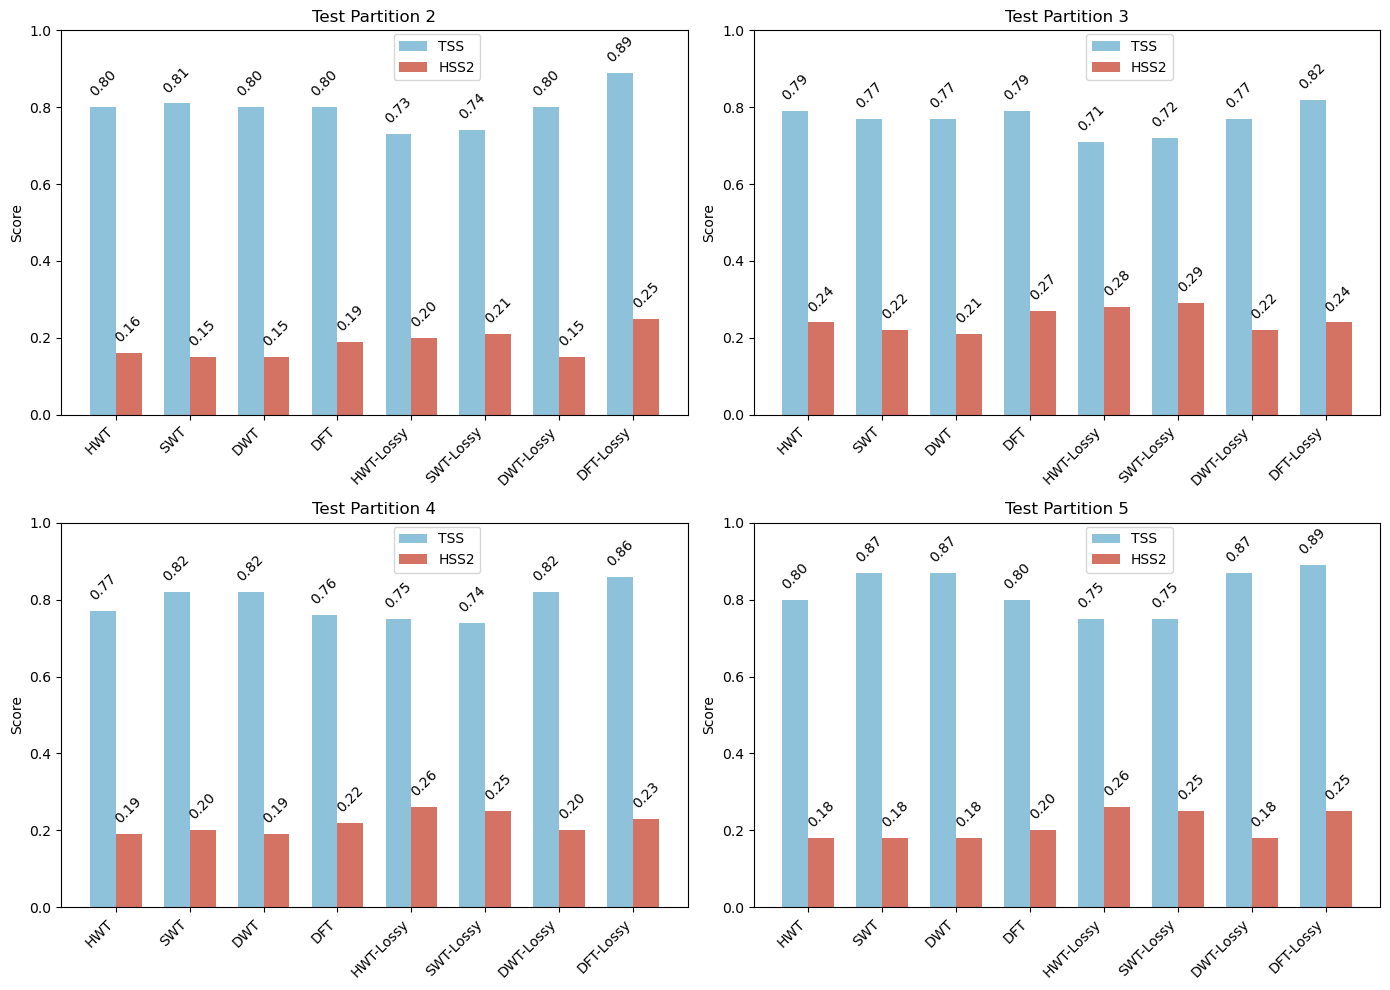

In [8]:

# Define your methods
methods = ['HWT', 'SWT', 'DWT', 'DFT', 
           'HWT-Lossy', 'SWT-Lossy', 'DWT-Lossy', 'DFT-Lossy']

# Initialize arrays for TSS and HSS2 scores for each partition
partition_TSS_scores = {
    'Test Partition 2': [0.80, 0.81, 0.80, 0.80, 0.73, 0.74, 0.80, 0.89],
    'Test Partition 3': [0.79, 0.77, 0.77, 0.79, 0.71, 0.72, 0.77, 0.82],
    'Test Partition 4': [0.77, 0.82, 0.82, 0.76, 0.75, 0.74, 0.82, 0.86],
    'Test Partition 5': [0.80, 0.87, 0.87, 0.80, 0.75, 0.75, 0.87, 0.89],
}

partition_HSS2_scores = {
    'Test Partition 2': [0.16, 0.15, 0.15, 0.19, 0.20, 0.21, 0.15, 0.25],
    'Test Partition 3': [0.24, 0.22, 0.21, 0.27, 0.28, 0.29, 0.22, 0.24],
    'Test Partition 4': [0.19, 0.20, 0.19, 0.22, 0.26, 0.25, 0.20, 0.23],
    'Test Partition 5': [0.18, 0.18, 0.18, 0.20, 0.26, 0.25, 0.18, 0.25],
}

# Define partition names
partition_names = ['Test Partition 2', 'Test Partition 3', 'Test Partition 4', 'Test Partition 5']

# Set width for the bars and position of the bars for grouping
bar_width = 0.35
index = np.arange(len(methods))

# Create subplots using matplotlib
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Iterate over partitions and create bar charts
for i, partition in enumerate(partition_names):
    row = i // 2
    col = i % 2
    
    TSS = partition_TSS_scores[partition]
    HSS2 = partition_HSS2_scores[partition]
    
    # Plotting the TSS scores as grouped bars
    axes[row, col].bar(index, TSS, bar_width, label='TSS', color='#8ec1da')
    # Add TSS text labels directly on top of the bars with diagonal rotation
    for idx, value in enumerate(TSS):
        axes[row, col].text(index[idx], value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=10, rotation=45)
    
    # Plotting the HSS2 scores as grouped bars
    axes[row, col].bar(index + bar_width, HSS2, bar_width, label='HSS2', color='#d47264')
    # Add HSS2 text labels directly on top of the bars with diagonal rotation
    for idx, value in enumerate(HSS2):
        axes[row, col].text(index[idx] + bar_width, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=10, rotation=45)
    
    # Set plot labels and title
    axes[row, col].set_title(partition)
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_xticks(index + bar_width / 2)
    axes[row, col].set_xticklabels(methods, rotation=45, ha='right')
    axes[row, col].set_ylim([0, 1])
    # Adjust legend position nearer to the center within the frame
    axes[row, col].legend(loc='center', bbox_to_anchor=(0.6, 0.93))

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('yourlocation')

# Show the plot
plt.show()


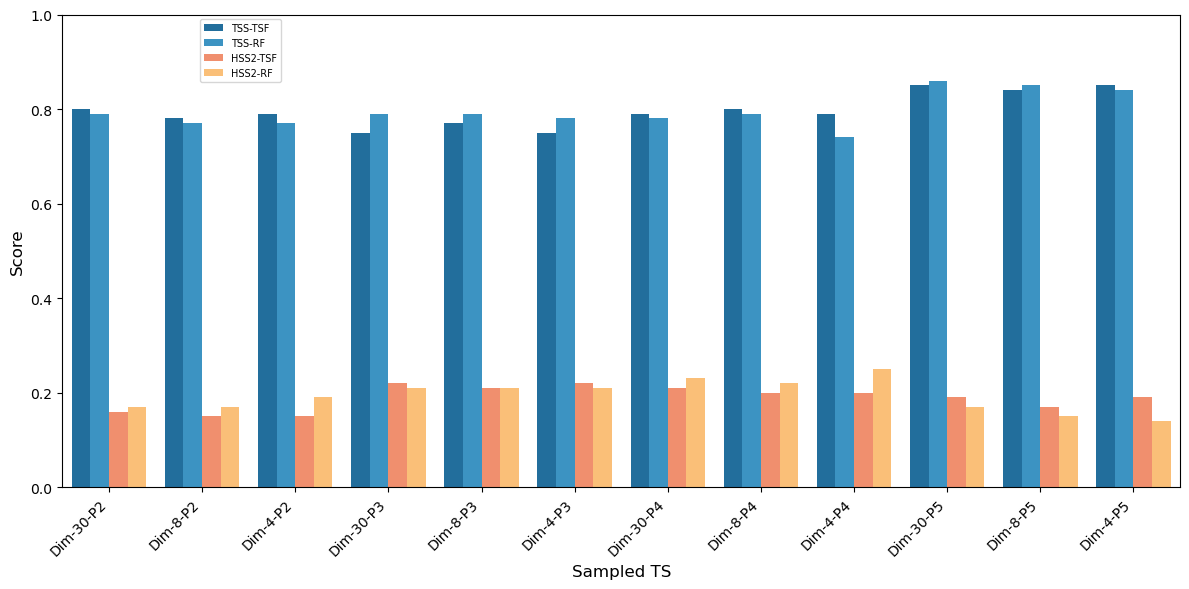

In [44]:
# Data
partitions = 4
dimensions = [30, 8, 4]

# Original data for TSS, HSS2, TSS-NTS, and HSS2-NTS
tss_ts_scores = np.array([
    [0.80, 0.78, 0.79],
    [0.75, 0.77, 0.75],
    [0.79, 0.80, 0.79],
    [0.85, 0.84, 0.85]
])

hss_ts_scores = np.array([
    [0.16, 0.15, 0.15],
    [0.22, 0.21, 0.22],
    [0.21, 0.20, 0.20],
    [0.19, 0.17, 0.19]
])

tss_nts_scores = np.array([
    [0.79, 0.77, 0.77],
    [0.79, 0.79, 0.78],
    [0.78, 0.79, 0.74],
    [0.86, 0.85, 0.84]
])

hss_nts_scores = np.array([
    [0.17, 0.17, 0.19],
    [0.21, 0.21, 0.21],
    [0.23, 0.22, 0.25],
    [0.17, 0.15, 0.14]
])

# Preparing data
num_partitions = len(tss_ts_scores)
num_dimensions = len(dimensions)
x_labels = [f'Dim-{dim}-P{i+2}' for i in range(num_partitions) for dim in dimensions]

# Flatten the scores for plotting
tss_ts_means = tss_ts_scores.flatten()
hss_ts_means = hss_ts_scores.flatten()
tss_nts_means = tss_nts_scores.flatten()
hss_nts_means = hss_nts_scores.flatten()

# Bar positions and width
x = np.arange(len(x_labels))  # the label locations
width = 0.2  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adding bars for each group with muted colors
bars1 = ax.bar(x - 1.5 * width, tss_ts_means, width, label='TSS-TSF', color='#226E9C')  # SlateGray
bars2 = ax.bar(x - 0.5 * width, tss_nts_means, width, label='TSS-RF', color='#3C93C2')  # CadetBlue
bars3 = ax.bar(x + 0.5 * width, hss_ts_means, width, label='HSS2-TSF', color='#F08F6E')  # LightTeal
bars4 = ax.bar(x + 1.5 * width, hss_nts_means, width, label='HSS2-RF', color='#FABF78')  # MediumTeal

# Formatting the plot
ax.set_xlabel('Sampled TS', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1.0)

# Adjust x-axis limits to move the plot closer to the y-axis
ax.set_xlim(-0.5, len(x_labels) - 0.5)

# Place the legend inside the plot (upper right corner)
ax.legend(loc='upper right', bbox_to_anchor=(0.2, 1.0), fontsize=7)


plt.savefig('yourlocation')

# Adjust layout to bring the plot closer to the y-axis
plt.tight_layout()

# Show the plot
plt.show()


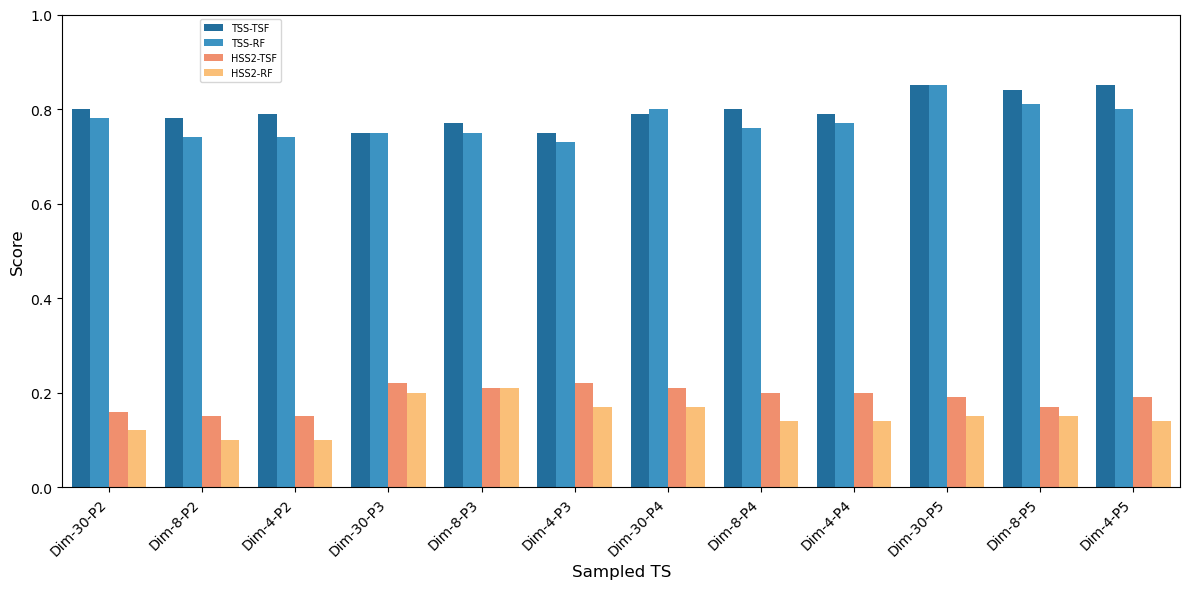

In [45]:
#haar
# Set the Plotly White theme
pio.templates.default = "plotly_white"

# Data (modified to include only the first element)
partitions = 4
dimensions = [30, 8, 4]

# Original data for TSS, HSS2, TSS-NTS, and HSS2-NTS
tss_ts_scores = np.array([
    [0.80, 0.78, 0.79],
    [0.75, 0.77, 0.75],
    [0.79, 0.80, 0.79],
    [0.85, 0.84, 0.85]
])

hss_ts_scores = np.array([
    [0.16, 0.15, 0.15],
    [0.22, 0.21, 0.22],
    [0.21, 0.20, 0.20],
    [0.19, 0.17, 0.19]
])

tss_nts_scores = np.array([
    [0.78, 0.74, 0.74],
    [0.75, 0.75, 0.73],
    [0.80, 0.76, 0.77],
    [0.85, 0.81, 0.80]
])

hss_nts_scores = np.array([
    [0.12, 0.10, 0.10],
    [0.20, 0.21, 0.17],
    [0.17, 0.14, 0.14],
    [0.15, 0.15, 0.14]
])

# Preparing data
num_partitions = len(tss_ts_scores)
num_dimensions = len(dimensions)
x_labels = [f'Dim-{dim}-P{i+2}' for i in range(num_partitions) for dim in dimensions]

# Flatten the scores for plotting
tss_ts_means = tss_ts_scores.flatten()
hss_ts_means = hss_ts_scores.flatten()
tss_nts_means = tss_nts_scores.flatten()
hss_nts_means = hss_nts_scores.flatten()

# Bar positions and width
x = np.arange(len(x_labels))  # the label locations
width = 0.2  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adding bars for each group with muted colors
bars1 = ax.bar(x - 1.5 * width, tss_ts_means, width, label='TSS-TSF', color='#226E9C')  # SlateGray
bars2 = ax.bar(x - 0.5 * width, tss_nts_means, width, label='TSS-RF', color='#3C93C2')  # CadetBlue
bars3 = ax.bar(x + 0.5 * width, hss_ts_means, width, label='HSS2-TSF', color='#F08F6E')  # LightTeal
bars4 = ax.bar(x + 1.5 * width, hss_nts_means, width, label='HSS2-RF', color='#FABF78')  # MediumTeal
# Formatting the plot
ax.set_xlabel('Sampled TS', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1.0)

# Adjust x-axis limits to move the plot closer to the y-axis
ax.set_xlim(-0.5, len(x_labels) - 0.5)

# Place the legend inside the plot (upper right corner)
ax.legend(loc='upper right', bbox_to_anchor=(0.2, 1.0), fontsize=7)
plt.savefig('yourlocation')

# Adjust layout to bring the plot closer to the y-axis
plt.tight_layout()

# Show the plot
plt.show()


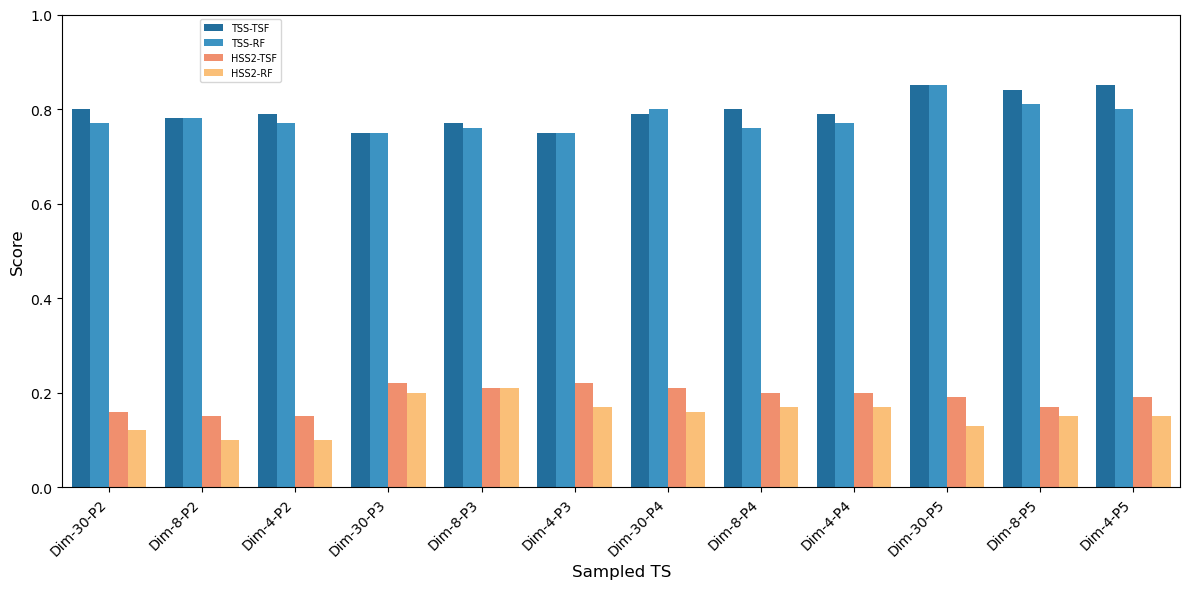

In [46]:
#daubechies
# Set the Plotly White theme
pio.templates.default = "plotly_white"

# Data (modified to include only the first element)
partitions = 4
dimensions = [30, 8, 4]

# Original data for TSS, HSS2, TSS-NTS, and HSS2-NTS
tss_ts_scores = np.array([
    [0.80, 0.78, 0.79],
    [0.75, 0.77, 0.75],
    [0.79, 0.80, 0.79],
    [0.85, 0.84, 0.85]
])

hss_ts_scores = np.array([
    [0.16, 0.15, 0.15],
    [0.22, 0.21, 0.22],
    [0.21, 0.20, 0.20],
    [0.19, 0.17, 0.19]
])

tss_nts_scores = np.array([
    [0.77, 0.78, 0.77],
    [0.75, 0.76, 0.75],
    [0.80, 0.76, 0.77],
    [0.85, 0.81, 0.80]
])

hss_nts_scores = np.array([
    [0.12, 0.10, 0.10],
    [0.20, 0.21, 0.17],
    [0.16, 0.17, 0.17],
    [0.13, 0.15, 0.15]
])

# Preparing data
num_partitions = len(tss_ts_scores)
num_dimensions = len(dimensions)
x_labels = [f'Dim-{dim}-P{i+2}' for i in range(num_partitions) for dim in dimensions]

# Flatten the scores for plotting
tss_ts_means = tss_ts_scores.flatten()
hss_ts_means = hss_ts_scores.flatten()
tss_nts_means = tss_nts_scores.flatten()
hss_nts_means = hss_nts_scores.flatten()

# Bar positions and width
x = np.arange(len(x_labels))  # the label locations
width = 0.2  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adding bars for each group with muted colors
bars1 = ax.bar(x - 1.5 * width, tss_ts_means, width, label='TSS-TSF', color='#226E9C')  # SlateGray
bars2 = ax.bar(x - 0.5 * width, tss_nts_means, width, label='TSS-RF', color='#3C93C2')  # CadetBlue
bars3 = ax.bar(x + 0.5 * width, hss_ts_means, width, label='HSS2-TSF', color='#F08F6E')  # LightTeal
bars4 = ax.bar(x + 1.5 * width, hss_nts_means, width, label='HSS2-RF', color='#FABF78')  # MediumTeal

# Formatting the plot
ax.set_xlabel('Sampled TS', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1.0)

# Adjust x-axis limits to move the plot closer to the y-axis
ax.set_xlim(-0.5, len(x_labels) - 0.5)

# Place the legend inside the plot (upper right corner)
ax.legend(loc='upper right', bbox_to_anchor=(0.2, 1.0), fontsize=7)
        
plt.savefig('yourlocation')

# Adjust layout to bring the plot closer to the y-axis
plt.tight_layout()

# Show the plot
plt.show()


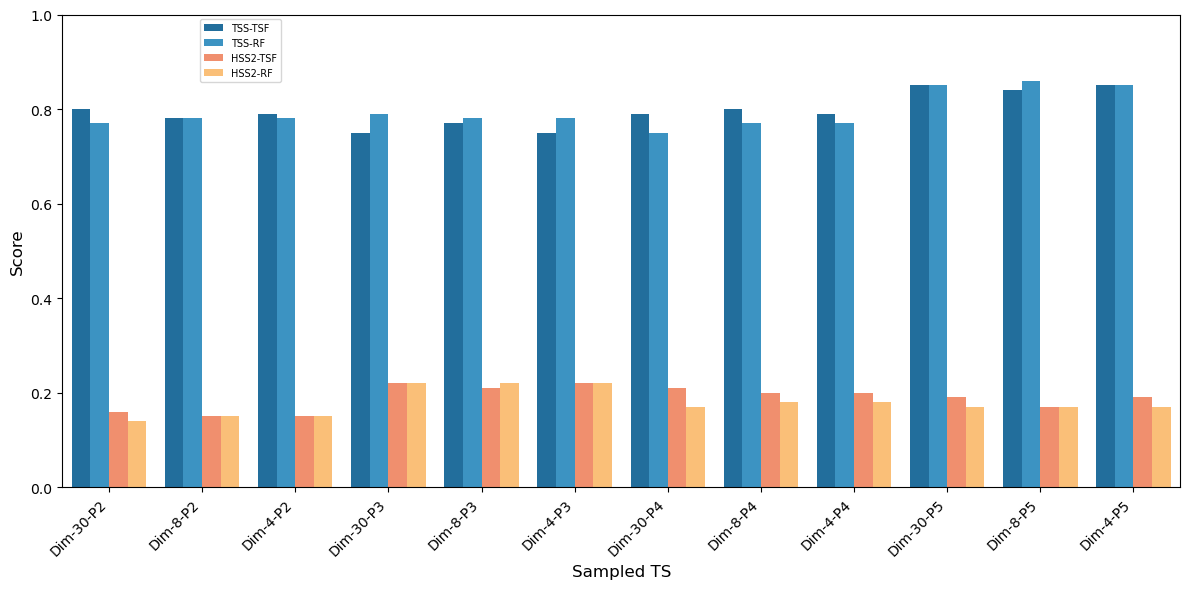

In [47]:
#symlets
# Set the Plotly White theme
pio.templates.default = "plotly_white"

# Data (modified to include only the first element)
partitions = 4
dimensions = [30, 8, 4]

# Original data for TSS, HSS2, TSS-NTS, and HSS2-NTS
tss_ts_scores = np.array([
    [0.80, 0.78, 0.79],
    [0.75, 0.77, 0.75],
    [0.79, 0.80, 0.79],
    [0.85, 0.84, 0.85]
])

hss_ts_scores = np.array([
    [0.16, 0.15, 0.15],
    [0.22, 0.21, 0.22],
    [0.21, 0.20, 0.20],
    [0.19, 0.17, 0.19]
])

tss_nts_scores = np.array([
    [0.77, 0.78, 0.78],
    [0.79, 0.78, 0.78],
    [0.75, 0.77, 0.77],
    [0.85, 0.86, 0.85]
])

hss_nts_scores = np.array([
    [0.14, 0.15, 0.15],
    [0.22, 0.22, 0.22],
    [0.17, 0.18, 0.18],
    [0.17, 0.17, 0.17]
])

# Preparing data
num_partitions = len(tss_ts_scores)
num_dimensions = len(dimensions)
x_labels = [f'Dim-{dim}-P{i+2}' for i in range(num_partitions) for dim in dimensions]

# Flatten the scores for plotting
tss_ts_means = tss_ts_scores.flatten()
hss_ts_means = hss_ts_scores.flatten()
tss_nts_means = tss_nts_scores.flatten()
hss_nts_means = hss_nts_scores.flatten()

# Bar positions and width
x = np.arange(len(x_labels))  # the label locations
width = 0.2  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Adding bars for each group with muted colors
bars1 = ax.bar(x - 1.5 * width, tss_ts_means, width, label='TSS-TSF', color='#226E9C')  # SlateGray
bars2 = ax.bar(x - 0.5 * width, tss_nts_means, width, label='TSS-RF', color='#3C93C2')  # CadetBlue
bars3 = ax.bar(x + 0.5 * width, hss_ts_means, width, label='HSS2-TSF', color='#F08F6E')  # LightTeal
bars4 = ax.bar(x + 1.5 * width, hss_nts_means, width, label='HSS2-RF', color='#FABF78')  # MediumTeal

# Formatting the plot
ax.set_xlabel('Sampled TS', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1.0)

# Adjust x-axis limits to move the plot closer to the y-axis
ax.set_xlim(-0.5, len(x_labels) - 0.5)

# Place the legend inside the plot (upper right corner)
ax.legend(loc='upper right', bbox_to_anchor=(0.2, 1.0), fontsize=7)
        
plt.savefig('yourlocation')

# Adjust layout to bring the plot closer to the y-axis
plt.tight_layout()

# Show the plot
plt.show()
